In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 4, 6, 28, 28
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):      
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [4]:
def train(model, criterion, optimizer, trainloader, valloader, epochs):
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] training loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

        # 计算在验证集上的loss和准确度
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_loss_history.append(running_loss / len(trainloader))
        val_loss_history.append(val_running_loss / len(valloader))
        val_accuracy_history.append(100 * correct / total)

        print('Epoch %d: Validation accuracy %d %%' % (epoch + 1, 100 * correct / total))
    PATH = './cifar_10_net.pth'
    torch.save(net.state_dict(), PATH)

    return train_loss_history, val_loss_history, val_accuracy_history

[1,  2000] training loss: 2.195
[1,  4000] training loss: 1.864
[1,  6000] training loss: 1.674
[1,  8000] training loss: 1.578
[1, 10000] training loss: 1.529
[1, 12000] training loss: 1.469
Epoch 1: Validation accuracy 45 %
[2,  2000] training loss: 1.387
[2,  4000] training loss: 1.349
[2,  6000] training loss: 1.349
[2,  8000] training loss: 1.314
[2, 10000] training loss: 1.287
[2, 12000] training loss: 1.275
Epoch 2: Validation accuracy 55 %
[3,  2000] training loss: 1.197
[3,  4000] training loss: 1.192
[3,  6000] training loss: 1.183
[3,  8000] training loss: 1.196
[3, 10000] training loss: 1.171
[3, 12000] training loss: 1.164
Epoch 3: Validation accuracy 57 %
[4,  2000] training loss: 1.127
[4,  4000] training loss: 1.091
[4,  6000] training loss: 1.095
[4,  8000] training loss: 1.092
[4, 10000] training loss: 1.077
[4, 12000] training loss: 1.078
Epoch 4: Validation accuracy 61 %
[5,  2000] training loss: 0.997
[5,  4000] training loss: 1.026
[5,  6000] training loss: 1.016


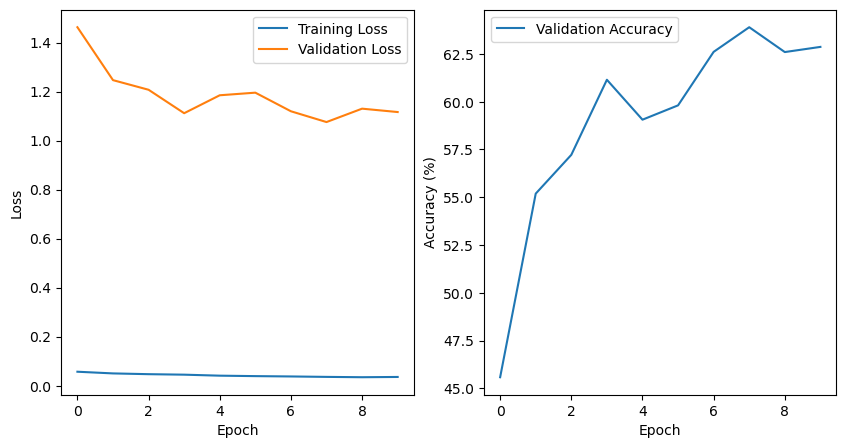

In [5]:
import matplotlib.pyplot as plt
# 训练模型并获取loss和accuracy曲线数据
train_loss, val_loss, val_accuracy = train(net, criterion, optimizer, trainloader, testloader, epochs=10)

# 绘制loss曲线和accuracy曲线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()